# Distributed Asynchronous Hyper-parameter Optimization with NGBoost

## Notes on Hyperopt

Hyperopt will allow us to intelligently narrow our search space over traditioanl methods like grid search in sklearn and thus save runtime when tuning our NGBoost model.

Original Article:

*Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. To appear in Proc. of the 30th International Conference on Machine Learning (ICML 2013).*

For install instructions and more information on how Hyperopt works click [here](http://hyperopt.github.io/hyperopt/)


## Import Dependencies

In [67]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from hyperopt import hp, tpe, space_eval
from hyperopt.pyll.base import scope
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials
import pandas as pd
import seaborn as sns
import warnings
import logging

## Setup basic logging

In [68]:
logging.basicConfig(
    # filename = "errors.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger()

## Load the Boston Housing Dataset

For this example we will be splitting the dataset into train/test/validation sets

In [69]:
boston = load_boston()
data = boston.data
target = boston.target

X_intermediate, X_test, y_intermediate, y_test = train_test_split(data, 
                                                                  target, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=1)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=1)

# delete intermediate variables
del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(target),2),
                                                       round(len(y_validation)/len(target),2),
                                                       round(len(y_test)/len(target),2)))

train: 0.6% | validation: 0.2% | test 0.2%


## Setup the Hyper-Parameters to test

Note:
- hp.choice selects from the provided list
- hp.uniform will iterate at random over the range provided like .05 to 1

In [70]:
b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)
b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)

space = {
    'learning_rate':hp.uniform('learning_rate', .05, 1),
    'minibatch_frac':hp.choice('minibatch_frac', [1.0, 0.5]),
    'Base':hp.choice('Base', [b1, b2, b3])
}

default_params = {"n_estimators":20,
                  "verbose_eval":1,
                  "random_state":1}

## Setup the model to be tested and log the loss for each test

Note: This example uses early stopping

This objective will log the loss of the best iteration among each pass (n_estimators) using best_val_loss_itr from the NGBRegressor object

In [71]:
def objective(params):
    
    params.update(default_params)
    
    print(params)
    ngb = NGBRegressor(**params).fit(X_train,y_train,X_val=X_validation, Y_val=y_validation, early_stopping_rounds=2)
    loss = ngb.evals_result['val']['LOGSCORE'][ngb.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

## Run tuning

We can modify max_evals here to adjust how many differnt sets of hyper-parameters we want to test

In [72]:
TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

2020-07-14 18:08:57 INFO     Start parameter optimization...


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2020-07-14 18:08:57 INFO     build_posterior_wrapper took 0.001346 seconds
2020-07-14 18:08:57 INFO     TPE using 0 trials


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9963402322326332, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3269 scale=0.5000 norm=3.2975
[iter 1] loss=3.2514 val_loss=2.9377 scale=1.0000 norm=4.2335
[iter 2] loss=2.8680 val_loss=2.7285 scale=2.0000 norm=4.6856
[iter 3] loss=2.5127 val_loss=2.7453 scale=1.0000 norm=2.4242
== Early stopping achieved.                            
== Best iteration / VAL 2 (val_loss=2.7285)            
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9963402322326332, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001223 seconds
2020-07-14 18:08:58 INFO     TPE using 1/1 trials with best loss 2.728550


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.33791984877178066, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3950 scale=0.5000 norm=3.2975                   
[iter 1] loss=3.3558 val_loss=3.3001 scale=0.5000 norm=2.8218                   
[iter 2] loss=3.2510 val_loss=3.1387 scale=1.0000 norm=4.8681                   
[iter 3] loss=3.0816 val_loss=2.9924 scale=1.0000 norm=3.6628                   
[iter 4] loss=2.9257 val_loss=2.7638 scale=2.0000 norm=5.7199                   
[iter 5] loss=2.6408 val_loss=2.6130 scale=2.0000 norm=3.8275                   
[iter 6] loss=2.3856 val_loss=2.5321 scale=2.0000 norm=3.2121                   
[iter 7] loss=2.1518 val_loss=2.6122 scale=2.0000 norm=2.7651                   
== Early stopping achieved.                                                     
== Best iteration / VAL 6 (val_loss=2.5321)                                     


2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.33791984877178066, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  2%|▏         | 2/100 [00:00<00:09, 10.42trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001215 seconds
2020-07-14 18:08:58 INFO     TPE using 2/2 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.05505562296841559, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.6260 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4996 val_loss=3.5840 scale=0.5000 norm=2.9837                    
[iter 2] loss=3.5221 val_loss=3.5575 scale=0.5000 norm=3.1320                    
[iter 3] loss=3.4751 val_loss=3.4984 scale=1.0000 norm=6.1057                    
[iter 4] loss=3.4237 val_loss=3.4671 scale=1.0000 norm=5.8252                    
[iter 5] loss=3.4047 val_loss=3.4508 scale=0.5000 norm=2.8576                    
[iter 6] loss=3.3997 val_loss=3.4146 scale=1.0000 norm=5.7392                    
[iter 7] loss=3.3783 val_loss=3.3891 scale=1.0000 norm=5.5398                    
[iter 8] loss=3.3484 val_loss=3.3565 scale=1.0000 norm=5.5641                    
[iter 9] loss=3.2861 val_loss=3.3380 scale=1.0000 norm=4.9649           

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.05505562296841559, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  3%|▎         | 3/100 [00:00<00:13,  7.42trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001437 seconds
2020-07-14 18:08:58 INFO     TPE using 3/3 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5866754949542182, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3853 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2691 val_loss=3.1382 scale=1.0000 norm=4.6849                    
[iter 2] loss=3.0532 val_loss=2.8676 scale=2.0000 norm=6.3032                    
[iter 3] loss=2.6238 val_loss=3.0080 scale=2.0000 norm=4.1169                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.8676)                                      
  3%|▎         | 3/100 [00:00<00:13,  7.42trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5866754949542182, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001194 seconds
2020-07-14 18:08:58 INFO     TPE using 4/4 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9245536370638938, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3249 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2345 val_loss=3.0604 scale=1.0000 norm=4.1444                    
[iter 2] loss=2.9308 val_loss=3.9784 scale=2.0000 norm=5.5366                    
== Early stopping achieved.                                                      
== Best iteration / VAL 1 (val_loss=3.0604)                                      
  4%|▍         | 4/100 [00:00<00:12,  7.42trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9245536370638938, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  5%|▌         | 5/100 [00:00<00:10,  8.81trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001323 seconds
2020-07-14 18:08:58 INFO     TPE using 5/5 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09023043148244542, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5592 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5125 val_loss=3.5034 scale=0.5000 norm=3.1802                    
[iter 2] loss=3.4593 val_loss=3.4625 scale=0.5000 norm=3.0722                    
[iter 3] loss=3.4184 val_loss=3.4257 scale=0.5000 norm=2.9708                    
[iter 4] loss=3.3837 val_loss=3.3683 scale=1.0000 norm=5.7415                    
[iter 5] loss=3.3243 val_loss=3.3199 scale=1.0000 norm=5.3821                    
[iter 6] loss=3.2724 val_loss=3.2715 scale=1.0000 norm=5.0511                    
[iter 7] loss=3.2258 val_loss=3.2297 scale=1.0000 norm=4.7466                    
[iter 8] loss=3.1827 val_loss=3.1879 scale=1.0000 norm=4.4735                    
[iter 9] loss=3.1398 val_loss=3.1484 scale=1.0000 norm=4.1987           

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09023043148244542, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  6%|▌         | 6/100 [00:00<00:15,  6.24trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001241 seconds
2020-07-14 18:08:58 INFO     TPE using 6/6 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6435288674704552, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3886 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2723 val_loss=3.1079 scale=1.0000 norm=4.6840                    
[iter 2] loss=3.0331 val_loss=3.0537 scale=2.0000 norm=6.4401                    
[iter 3] loss=2.6409 val_loss=3.3844 scale=2.0000 norm=4.6255                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=3.0537)                                      
  6%|▌         | 6/100 [00:00<00:15,  6.24trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6435288674704552, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001153 seconds
2020-07-14 18:08:58 INFO     TPE using 7/7 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.6981195740733745, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4021 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2902 val_loss=3.2045 scale=1.0000 norm=4.6121                    
[iter 2] loss=3.0802 val_loss=3.0791 scale=2.0000 norm=7.0495                    
[iter 3] loss=2.7176 val_loss=3.3736 scale=2.0000 norm=5.4563                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=3.0791)                                      
  7%|▋         | 7/100 [00:00<00:14,  6.24trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.6981195740733745, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  8%|▊         | 8/100 [00:00<00:12,  7.61trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:58 INFO     build_posterior_wrapper took 0.001042 seconds
2020-07-14 18:08:58 INFO     TPE using 8/8 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.22806949707798607, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5321 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4203 val_loss=3.3795 scale=1.0000 norm=5.5759                    
[iter 2] loss=3.3509 val_loss=3.2827 scale=1.0000 norm=5.2707                    
[iter 3] loss=3.1744 val_loss=3.1951 scale=1.0000 norm=4.2475                    
[iter 4] loss=3.0986 val_loss=3.1201 scale=1.0000 norm=3.8035                    
[iter 5] loss=3.0456 val_loss=2.9527 scale=2.0000 norm=7.2354                    
[iter 6] loss=2.8888 val_loss=2.8979 scale=1.0000 norm=3.2915                    
[iter 7] loss=2.8417 val_loss=2.8111 scale=2.0000 norm=6.2718                    
[iter 8] loss=2.6743 val_loss=2.7916 scale=2.0000 norm=5.2815                    
[iter 9] loss=2.5593 val_loss=2.7995 scale=2.0000 norm=4.8415           

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.22806949707798607, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  9%|▉         | 9/100 [00:01<00:12,  7.26trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-14 18:08:59 INFO     TPE using 9/9 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.8929586004117932, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3306 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2621 val_loss=2.9667 scale=1.0000 norm=4.4550                    
[iter 2] loss=2.9031 val_loss=2.6989 scale=2.0000 norm=4.8950                    
[iter 3] loss=2.5119 val_loss=3.0093 scale=2.0000 norm=4.7961                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.6989)                                      
  9%|▉         | 9/100 [00:01<00:12,  7.26trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.8929586004117932, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001033 seconds
2020-07-14 18:08:59 INFO     TPE using 10/10 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23432861944672212, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4968 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3821 val_loss=3.3354 scale=1.0000 norm=5.4980                     
[iter 2] loss=3.2750 val_loss=3.1904 scale=1.0000 norm=4.8024                     
[iter 3] loss=3.1206 val_loss=3.0848 scale=1.0000 norm=3.9294                     
[iter 4] loss=3.0169 val_loss=2.9897 scale=1.0000 norm=3.3332                     
[iter 5] loss=2.9194 val_loss=2.8101 scale=2.0000 norm=6.0688                     
[iter 6] loss=2.7467 val_loss=2.6806 scale=2.0000 norm=4.9381                     
[iter 7] loss=2.5731 val_loss=2.5820 scale=2.0000 norm=4.0431                     
[iter 8] loss=2.4175 val_loss=2.5463 scale=2.0000 norm=3.5416                     
[iter 9] loss=2.3308 val_loss=2.5949 scale=2.0000 norm=3.6764  

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23432861944672212, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 11%|█         | 11/100 [00:01<00:11,  7.83trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001393 seconds
2020-07-14 18:08:59 INFO     TPE using 11/11 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9694790746600209, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3169 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2739 val_loss=3.0659 scale=1.0000 norm=4.4867                     
[iter 2] loss=2.9621 val_loss=3.1737 scale=2.0000 norm=6.2983                     
== Early stopping achieved.                                                       
== Best iteration / VAL 1 (val_loss=3.0659)                                       
 11%|█         | 11/100 [00:01<00:11,  7.83trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9694790746600209, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001312 seconds
2020-07-14 18:08:59 INFO     TPE using 12/12 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.6170719286783258, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3611 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3291 val_loss=3.1488 scale=1.0000 norm=5.1779                     
[iter 2] loss=3.0889 val_loss=2.8856 scale=2.0000 norm=7.5436                     
[iter 3] loss=2.7794 val_loss=2.8800 scale=2.0000 norm=5.7920                     
[iter 4] loss=2.6859 val_loss=2.9061 scale=1.0000 norm=2.7842                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.8800)                                       
 12%|█▏        | 12/100 [00:01<00:11,  7.83trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.6170719286783258, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 13%|█▎        | 13/100 [00:01<00:09,  9.19trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001261 seconds
2020-07-14 18:08:59 INFO     TPE using 13/13 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9727959498950404, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3341 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.2190 val_loss=3.0211 scale=1.0000 norm=4.0546                     
[iter 2] loss=2.9108 val_loss=3.9579 scale=2.0000 norm=5.3657                     
== Early stopping achieved.                                                       
== Best iteration / VAL 1 (val_loss=3.0211)                                       
 13%|█▎        | 13/100 [00:01<00:09,  9.19trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9727959498950404, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001030 seconds
2020-07-14 18:08:59 INFO     TPE using 14/14 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.37514002546394026, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4636 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3503 val_loss=3.2460 scale=1.0000 norm=5.2376                     
[iter 2] loss=3.1993 val_loss=3.0944 scale=1.0000 norm=4.2307                     
[iter 3] loss=2.9924 val_loss=2.8855 scale=2.0000 norm=6.2496                     
[iter 4] loss=2.7062 val_loss=2.7735 scale=2.0000 norm=4.3297                     
[iter 5] loss=2.6924 val_loss=2.8047 scale=2.0000 norm=4.8800                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.7735)                                       
 14%|█▍        | 14/100 [00:01<00:09,  9.19trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.37514002546394026, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 15%|█▌        | 15/100 [00:01<00:08, 10.28trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001218 seconds
2020-07-14 18:08:59 INFO     TPE using 15/15 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06165005790740385, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.6158 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4853 val_loss=3.5645 scale=0.5000 norm=2.9681                     
[iter 2] loss=3.4954 val_loss=3.5242 scale=0.5000 norm=3.0906                     
[iter 3] loss=3.4425 val_loss=3.4926 scale=0.5000 norm=3.0116                     
[iter 4] loss=3.4076 val_loss=3.4716 scale=0.5000 norm=2.8968                     
[iter 5] loss=3.3986 val_loss=3.4440 scale=0.5000 norm=2.8668                     
[iter 6] loss=3.3842 val_loss=3.4222 scale=0.5000 norm=2.8584                     
[iter 7] loss=3.3741 val_loss=3.3967 scale=0.5000 norm=2.8046                     
[iter 8] loss=3.3511 val_loss=3.3743 scale=0.5000 norm=2.8315                     
[iter 9] loss=3.2970 val_loss=3.3450 scale=1.0000 norm=5.0902  

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.06165005790740385, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-14 18:08:59 INFO     TPE using 16/16 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.8331585653188335, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3297 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2915 val_loss=3.0964 scale=1.0000 norm=4.7391                     
[iter 2] loss=3.0063 val_loss=2.9637 scale=2.0000 norm=6.6210                     
[iter 3] loss=2.7811 val_loss=2.9120 scale=1.0000 norm=3.1147                     
[iter 4] loss=2.6565 val_loss=2.9397 scale=1.0000 norm=2.7635                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.9120)                                       
 16%|█▌        | 16/100 [00:01<00:08, 10.28trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.8331585653188335, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 17%|█▋        | 17/100 [00:01<00:09,  8.39trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001356 seconds
2020-07-14 18:08:59 INFO     TPE using 17/17 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8375637756614579, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3023 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2355 val_loss=2.9837 scale=1.0000 norm=4.3228                     
[iter 2] loss=2.8798 val_loss=2.6598 scale=2.0000 norm=4.4468                     
[iter 3] loss=2.3833 val_loss=3.2803 scale=2.0000 norm=3.9961                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.6598)                                       
 17%|█▋        | 17/100 [00:01<00:09,  8.39trial/s, best loss: 2.5320742663167075]

2020-07-14 18:08:59 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8375637756614579, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:08:59 INFO     build_posterior_wrapper took 0.001140 seconds
2020-07-14 18:08:59 INFO     TPE using 18/18 trials with best loss 2.532074


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11777303039178975, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5343 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4913 val_loss=3.4721 scale=0.5000 norm=3.1452                     
[iter 2] loss=3.4307 val_loss=3.4263 scale=0.5000 norm=3.0074                     
[iter 3] loss=3.3848 val_loss=3.3524 scale=1.0000 norm=5.7604                     
[iter 4] loss=3.3081 val_loss=3.2895 scale=1.0000 norm=5.2681                     
[iter 5] loss=3.2440 val_loss=3.2400 scale=1.0000 norm=4.8494                     
[iter 6] loss=3.1856 val_loss=3.1859 scale=1.0000 norm=4.4717                     
[iter 7] loss=3.1298 val_loss=3.1391 scale=1.0000 norm=4.1155                     
[iter 8] loss=3.0764 val_loss=3.0897 scale=1.0000 norm=3.8054                     
[iter 9] loss=3.0241 val_loss=3.0420 scale=1.0000 norm=3.5371  

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11777303039178975, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 19%|█▉        | 19/100 [00:02<00:10,  7.55trial/s, best loss: 2.5150628240399553]

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001260 seconds
2020-07-14 18:09:00 INFO     TPE using 19/19 trials with best loss 2.515063


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.23200151949609193, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4850 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4496 val_loss=3.4156 scale=0.5000 norm=3.0165                     
[iter 2] loss=3.3709 val_loss=3.3016 scale=1.0000 norm=5.5965                     
[iter 3] loss=3.2498 val_loss=3.2045 scale=1.0000 norm=4.7988                     
[iter 4] loss=3.1532 val_loss=3.1202 scale=1.0000 norm=4.2281                     
[iter 5] loss=3.0544 val_loss=3.0522 scale=1.0000 norm=3.7100                     
[iter 6] loss=2.9649 val_loss=2.9416 scale=2.0000 norm=6.7255                     
[iter 7] loss=2.8181 val_loss=2.8753 scale=2.0000 norm=5.8586                     
[iter 8] loss=2.6758 val_loss=2.8306 scale=2.0000 norm=5.2404                     
[iter 9] loss=2.5630 val_loss=2.8020 scale=2.0000 norm=4.8692  

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.23200151949609193, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 20%|██        | 20/100 [00:02<00:10,  7.31trial/s, best loss: 2.5150628240399553]

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001260 seconds
2020-07-14 18:09:00 INFO     TPE using 20/20 trials with best loss 2.515063


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.41528473826364093, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3698 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3274 val_loss=3.1702 scale=1.0000 norm=5.4335                     
[iter 2] loss=3.1120 val_loss=3.0072 scale=1.0000 norm=3.7199                     
[iter 3] loss=2.9200 val_loss=2.7259 scale=2.0000 norm=5.4568                     
[iter 4] loss=2.5790 val_loss=2.5714 scale=2.0000 norm=3.4525                     
[iter 5] loss=2.2656 val_loss=2.6449 scale=2.0000 norm=2.8527                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5714)                                       
 20%|██        | 20/100 [00:02<00:10,  7.31trial/s, best loss: 2.5150628240399553]

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.41528473826364093, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 21%|██        | 21/100 [00:02<00:09,  7.93trial/s, best loss: 2.5150628240399553]

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001341 seconds
2020-07-14 18:09:00 INFO     TPE using 21/21 trials with best loss 2.515063


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.37106795460232533, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3836 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3430 val_loss=3.2842 scale=0.5000 norm=2.7766                     
[iter 2] loss=3.2327 val_loss=3.1129 scale=1.0000 norm=4.7227                     
[iter 3] loss=3.0524 val_loss=2.9571 scale=1.0000 norm=3.4618                     
[iter 4] loss=2.8842 val_loss=2.7050 scale=2.0000 norm=5.3322                     
[iter 5] loss=2.5815 val_loss=2.5515 scale=2.0000 norm=3.6201                     
[iter 6] loss=2.3184 val_loss=2.4776 scale=2.0000 norm=3.1492                     
[iter 7] loss=2.0884 val_loss=2.6605 scale=2.0000 norm=2.7816                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.4776)                    

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.37106795460232533, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 22%|██▏       | 22/100 [00:02<00:09,  7.86trial/s, best loss: 2.477601238237522] 

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001103 seconds
2020-07-14 18:09:00 INFO     TPE using 22/22 trials with best loss 2.477601


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49617062715526716, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3493 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3030 val_loss=3.1302 scale=1.0000 norm=5.2162                    
[iter 2] loss=3.0624 val_loss=2.9409 scale=1.0000 norm=3.3198                    
[iter 3] loss=2.8414 val_loss=2.6696 scale=2.0000 norm=4.7409                    
[iter 4] loss=2.4566 val_loss=2.5998 scale=2.0000 norm=3.3064                    
[iter 5] loss=2.1503 val_loss=2.8503 scale=2.0000 norm=2.9483                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.5998)                                      
 22%|██▏       | 22/100 [00:02<00:09,  7.86trial/s, best loss: 2.477601238237522]

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49617062715526716, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 23%|██▎       | 23/100 [00:02<00:09,  8.32trial/s, best loss: 2.477601238237522]

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001245 seconds
2020-07-14 18:09:00 INFO     TPE using 23/23 trials with best loss 2.477601


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1490889017525694, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4970 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4582 val_loss=3.4268 scale=0.5000 norm=3.0835                    
[iter 2] loss=3.3859 val_loss=3.3748 scale=0.5000 norm=2.8928                    
[iter 3] loss=3.3305 val_loss=3.2889 scale=1.0000 norm=5.4258                    
[iter 4] loss=3.2370 val_loss=3.2128 scale=1.0000 norm=4.7855                    
[iter 5] loss=3.1575 val_loss=3.1408 scale=1.0000 norm=4.2510                    
[iter 6] loss=3.0849 val_loss=3.0746 scale=1.0000 norm=3.7996                    
[iter 7] loss=3.0143 val_loss=3.0159 scale=1.0000 norm=3.4126                    
[iter 8] loss=2.9457 val_loss=2.9033 scale=2.0000 norm=6.1741                    
[iter 9] loss=2.8162 val_loss=2.7929 scale=2.0000 norm=5.1438            

2020-07-14 18:09:00 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1490889017525694, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 24%|██▍       | 24/100 [00:02<00:12,  6.32trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:00 INFO     build_posterior_wrapper took 0.001053 seconds
2020-07-14 18:09:00 INFO     TPE using 24/24 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3041063721735142, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4057 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3702 val_loss=3.3171 scale=0.5000 norm=2.8681                     
[iter 2] loss=3.2707 val_loss=3.1672 scale=1.0000 norm=5.0179                     
[iter 3] loss=3.1140 val_loss=3.0483 scale=1.0000 norm=3.8797                     
[iter 4] loss=2.9717 val_loss=2.8231 scale=2.0000 norm=6.1827                     
[iter 5] loss=2.7147 val_loss=2.6355 scale=2.0000 norm=4.2480                     
[iter 6] loss=2.4737 val_loss=2.5311 scale=2.0000 norm=3.3652                     
[iter 7] loss=2.2553 val_loss=2.5250 scale=2.0000 norm=2.9666                     
[iter 8] loss=2.0523 val_loss=2.6491 scale=2.0000 norm=2.6471                     
== Early stopping achieved.                                     

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3041063721735142, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 25%|██▌       | 25/100 [00:03<00:11,  6.55trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001202 seconds
2020-07-14 18:09:01 INFO     TPE using 25/25 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.47111332129027067, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3541 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3101 val_loss=3.1433 scale=1.0000 norm=5.2833                     
[iter 2] loss=3.0769 val_loss=2.9727 scale=1.0000 norm=3.4304                     
[iter 3] loss=2.8637 val_loss=2.6700 scale=2.0000 norm=4.8984                     
[iter 4] loss=2.4884 val_loss=2.5208 scale=2.0000 norm=3.1918                     
[iter 5] loss=2.1454 val_loss=2.6699 scale=2.0000 norm=2.6087                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5208)                                       
 25%|██▌       | 25/100 [00:03<00:11,  6.55trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.47111332129027067, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 26%|██▌       | 26/100 [00:03<00:10,  7.29trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001242 seconds
2020-07-14 18:09:01 INFO     TPE using 26/26 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13109051806993233, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5155 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4715 val_loss=3.4471 scale=0.5000 norm=3.1089                     
[iter 2] loss=3.4030 val_loss=3.3967 scale=0.5000 norm=2.9375                     
[iter 3] loss=3.3507 val_loss=3.3540 scale=0.5000 norm=2.7810                     
[iter 4] loss=3.3062 val_loss=3.2769 scale=1.0000 norm=5.2593                     
[iter 5] loss=3.2274 val_loss=3.2137 scale=1.0000 norm=4.7283                     
[iter 6] loss=3.1574 val_loss=3.1548 scale=1.0000 norm=4.2544                     
[iter 7] loss=3.0937 val_loss=3.1019 scale=1.0000 norm=3.8659                     
[iter 8] loss=3.0313 val_loss=3.0445 scale=1.0000 norm=3.5189                     
[iter 9] loss=2.9709 val_loss=2.9892 scale=1.0000 norm=3.2282  

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13109051806993233, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 27%|██▋       | 27/100 [00:03<00:13,  5.54trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001233 seconds
2020-07-14 18:09:01 INFO     TPE using 27/27 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18636696060588237, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4729 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4330 val_loss=3.3958 scale=0.5000 norm=3.0312                     
[iter 2] loss=3.3541 val_loss=3.3394 scale=0.5000 norm=2.7992                     
[iter 3] loss=3.2913 val_loss=3.2375 scale=1.0000 norm=5.1706                     
[iter 4] loss=3.1864 val_loss=3.1536 scale=1.0000 norm=4.4374                     
[iter 5] loss=3.0925 val_loss=3.0750 scale=1.0000 norm=3.8228                     
[iter 6] loss=3.0057 val_loss=2.9994 scale=1.0000 norm=3.3542                     
[iter 7] loss=2.9208 val_loss=2.8658 scale=2.0000 norm=5.8984                     
[iter 8] loss=2.7580 val_loss=2.7486 scale=2.0000 norm=4.6745                     
[iter 9] loss=2.6043 val_loss=2.6561 scale=2.0000 norm=3.9185  

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18636696060588237, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 28%|██▊       | 28/100 [00:03<00:13,  5.40trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001439 seconds
2020-07-14 18:09:01 INFO     TPE using 28/28 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.29018947699403147, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4153 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3766 val_loss=3.3264 scale=0.5000 norm=2.8872                     
[iter 2] loss=3.2793 val_loss=3.1806 scale=1.0000 norm=5.0819                     
[iter 3] loss=3.1275 val_loss=3.0653 scale=1.0000 norm=3.9796                     
[iter 4] loss=2.9909 val_loss=2.8411 scale=2.0000 norm=6.3927                     
[iter 5] loss=2.7437 val_loss=2.6898 scale=2.0000 norm=4.4092                     
[iter 6] loss=2.5105 val_loss=2.6251 scale=2.0000 norm=3.4231                     
[iter 7] loss=2.3037 val_loss=2.5768 scale=2.0000 norm=3.0692                     
[iter 8] loss=2.1062 val_loss=2.6610 scale=2.0000 norm=2.7008                     
== Early stopping achieved.                                    

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.29018947699403147, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 29%|██▉       | 29/100 [00:03<00:12,  5.88trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001182 seconds
2020-07-14 18:09:01 INFO     TPE using 29/29 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4157015165188113, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3691 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3273 val_loss=3.1723 scale=1.0000 norm=5.4323                     
[iter 2] loss=3.1114 val_loss=3.0090 scale=1.0000 norm=3.7176                     
[iter 3] loss=2.9189 val_loss=2.7209 scale=2.0000 norm=5.4525                     
[iter 4] loss=2.5772 val_loss=2.5523 scale=2.0000 norm=3.4507                     
[iter 5] loss=2.2632 val_loss=2.6182 scale=2.0000 norm=2.8519                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5523)                                       
 29%|██▉       | 29/100 [00:03<00:12,  5.88trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4157015165188113, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001249 seconds
2020-07-14 18:09:01 INFO     TPE using 30/30 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5507473932088368, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3386 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2889 val_loss=3.1029 scale=1.0000 norm=5.0707                     
[iter 2] loss=3.0274 val_loss=2.7158 scale=2.0000 norm=6.1395                     
[iter 3] loss=2.6021 val_loss=2.6063 scale=2.0000 norm=3.6599                     
[iter 4] loss=2.2233 val_loss=2.7601 scale=2.0000 norm=2.8980                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.6063)                                       
 30%|███       | 30/100 [00:04<00:11,  5.88trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5507473932088368, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 31%|███       | 31/100 [00:04<00:10,  6.82trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:01 INFO     build_posterior_wrapper took 0.001225 seconds
2020-07-14 18:09:01 INFO     TPE using 31/31 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18299728751289104, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4714 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4352 val_loss=3.3966 scale=0.5000 norm=3.0359                     
[iter 2] loss=3.3569 val_loss=3.3413 scale=0.5000 norm=2.8076                     
[iter 3] loss=3.2946 val_loss=3.2412 scale=1.0000 norm=5.1932                     
[iter 4] loss=3.1907 val_loss=3.1589 scale=1.0000 norm=4.4688                     
[iter 5] loss=3.0981 val_loss=3.0845 scale=1.0000 norm=3.8585                     
[iter 6] loss=3.0117 val_loss=3.0076 scale=1.0000 norm=3.3870                     
[iter 7] loss=2.9296 val_loss=2.8633 scale=2.0000 norm=6.0260                     
[iter 8] loss=2.7706 val_loss=2.7389 scale=2.0000 norm=4.8017                     
[iter 9] loss=2.6219 val_loss=2.6447 scale=2.0000 norm=4.0447  

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.18299728751289104, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 32%|███▏      | 32/100 [00:04<00:10,  6.20trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001214 seconds
2020-07-14 18:09:02 INFO     TPE using 32/32 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.31532162025100485, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4015 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3653 val_loss=3.3135 scale=0.5000 norm=2.8527                     
[iter 2] loss=3.2640 val_loss=3.1590 scale=1.0000 norm=4.9668                     
[iter 3] loss=3.1012 val_loss=3.0270 scale=1.0000 norm=3.8045                     
[iter 4] loss=2.9551 val_loss=2.8035 scale=2.0000 norm=6.0095                     
[iter 5] loss=2.6898 val_loss=2.6306 scale=2.0000 norm=4.1347                     
[iter 6] loss=2.4509 val_loss=2.5577 scale=2.0000 norm=3.3944                     
[iter 7] loss=2.2252 val_loss=2.5684 scale=2.0000 norm=2.9125                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5577)                    

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.31532162025100485, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 33%|███▎      | 33/100 [00:04<00:10,  6.65trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001040 seconds
2020-07-14 18:09:02 INFO     TPE using 33/33 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.686565604517095, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3202 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2601 val_loss=3.0284 scale=1.0000 norm=4.7126                     
[iter 2] loss=2.9539 val_loss=2.6694 scale=2.0000 norm=5.0873                     
[iter 3] loss=2.4740 val_loss=2.8731 scale=2.0000 norm=3.7711                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.6694)                                       
 33%|███▎      | 33/100 [00:04<00:10,  6.65trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.686565604517095, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001238 seconds
2020-07-14 18:09:02 INFO     TPE using 34/34 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.37977637974752976, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3783 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3398 val_loss=3.2798 scale=0.5000 norm=2.7648                     
[iter 2] loss=3.2280 val_loss=3.1084 scale=1.0000 norm=4.6851                     
[iter 3] loss=3.0444 val_loss=2.9554 scale=1.0000 norm=3.4144                     
[iter 4] loss=2.8723 val_loss=2.7227 scale=2.0000 norm=5.2031                     
[iter 5] loss=2.5642 val_loss=2.5850 scale=2.0000 norm=3.5256                     
[iter 6] loss=2.2858 val_loss=2.5661 scale=2.0000 norm=2.9864                     
[iter 7] loss=2.0484 val_loss=2.6912 scale=2.0000 norm=2.6852                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5661)                    

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.37977637974752976, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 35%|███▌      | 35/100 [00:04<00:08,  7.42trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001045 seconds
2020-07-14 18:09:02 INFO     TPE using 35/35 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.45738211650815974, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3572 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3142 val_loss=3.1504 scale=1.0000 norm=5.3201                     
[iter 2] loss=3.0854 val_loss=2.9797 scale=1.0000 norm=3.4993                     
[iter 3] loss=2.8773 val_loss=2.6747 scale=2.0000 norm=5.0174                     
[iter 4] loss=2.5100 val_loss=2.5128 scale=2.0000 norm=3.2204                     
[iter 5] loss=2.1702 val_loss=2.6497 scale=2.0000 norm=2.6276                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5128)                                       
 35%|███▌      | 35/100 [00:04<00:08,  7.42trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.45738211650815974, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001412 seconds
2020-07-14 18:09:02 INFO     TPE using 36/36 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05549021069427969, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5915 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5374 val_loss=3.5444 scale=0.5000 norm=3.2166                     
[iter 2] loss=3.4936 val_loss=3.5093 scale=0.5000 norm=3.1400                     
[iter 3] loss=3.4587 val_loss=3.4790 scale=0.5000 norm=3.0664                     
[iter 4] loss=3.4291 val_loss=3.4527 scale=0.5000 norm=2.9959                     
[iter 5] loss=3.4030 val_loss=3.4293 scale=0.5000 norm=2.9273                     
[iter 6] loss=3.3794 val_loss=3.4073 scale=0.5000 norm=2.8581                     
[iter 7] loss=3.3578 val_loss=3.3878 scale=0.5000 norm=2.7941                     
[iter 8] loss=3.3377 val_loss=3.3694 scale=0.5000 norm=2.7332                     
[iter 9] loss=3.3187 val_loss=3.3332 scale=1.0000 norm=5.3405  

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05549021069427969, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 37%|███▋      | 37/100 [00:04<00:09,  6.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001032 seconds
2020-07-14 18:09:02 INFO     TPE using 37/37 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5435087341292066, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3396 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2907 val_loss=3.1031 scale=1.0000 norm=5.0900                     
[iter 2] loss=3.0316 val_loss=2.7139 scale=2.0000 norm=6.2032                     
[iter 3] loss=2.6096 val_loss=2.6145 scale=2.0000 norm=3.6619                     
[iter 4] loss=2.2322 val_loss=2.8042 scale=2.0000 norm=2.8917                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.6145)                                       
 37%|███▋      | 37/100 [00:04<00:09,  6.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:02 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5435087341292066, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:02 INFO     build_posterior_wrapper took 0.001348 seconds
2020-07-14 18:09:02 INFO     TPE using 38/38 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.17454165257760326, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5398 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4239 val_loss=3.4495 scale=0.5000 norm=2.8369                     
[iter 2] loss=3.3969 val_loss=3.3960 scale=0.5000 norm=2.8384                     
[iter 3] loss=3.3101 val_loss=3.2985 scale=1.0000 norm=5.2240                     
[iter 4] loss=3.2153 val_loss=3.2321 scale=1.0000 norm=4.5806                     
[iter 5] loss=3.1677 val_loss=3.1649 scale=1.0000 norm=4.2356                     
[iter 6] loss=3.0772 val_loss=3.1076 scale=1.0000 norm=3.9162                     
[iter 7] loss=3.0015 val_loss=3.0366 scale=1.0000 norm=3.5259                     
[iter 8] loss=2.9440 val_loss=2.9908 scale=1.0000 norm=3.3635                     
[iter 9] loss=2.8471 val_loss=2.9198 scale=2.0000 norm=5.7154  

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.17454165257760326, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 39%|███▉      | 39/100 [00:05<00:08,  6.81trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001266 seconds
2020-07-14 18:09:03 INFO     TPE using 39/39 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.26368295031918326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4690 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4354 val_loss=3.3956 scale=0.5000 norm=2.9797                     
[iter 2] loss=3.3514 val_loss=3.2818 scale=1.0000 norm=5.4775                     
[iter 3] loss=3.2243 val_loss=3.1745 scale=1.0000 norm=4.6143                     
[iter 4] loss=3.1157 val_loss=3.0848 scale=1.0000 norm=4.0141                     
[iter 5] loss=3.0145 val_loss=2.9286 scale=2.0000 norm=7.0776                     
[iter 6] loss=2.8264 val_loss=2.8251 scale=2.0000 norm=5.8205                     
[iter 7] loss=2.6551 val_loss=2.7917 scale=2.0000 norm=4.9918                     
[iter 8] loss=2.5329 val_loss=2.7796 scale=2.0000 norm=4.7844                     
[iter 9] loss=2.4353 val_loss=2.8045 scale=2.0000 norm=4.5924  

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.26368295031918326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 40%|████      | 40/100 [00:05<00:08,  6.93trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001234 seconds
2020-07-14 18:09:03 INFO     TPE using 40/40 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3559374791337156, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3865 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3487 val_loss=3.2913 scale=0.5000 norm=2.7972                     
[iter 2] loss=3.2409 val_loss=3.1263 scale=1.0000 norm=4.7886                     
[iter 3] loss=3.0657 val_loss=2.9753 scale=1.0000 norm=3.5517                     
[iter 4] loss=2.9034 val_loss=2.7271 scale=2.0000 norm=5.5056                     
[iter 5] loss=2.6097 val_loss=2.5699 scale=2.0000 norm=3.7145                     
[iter 6] loss=2.3570 val_loss=2.4985 scale=2.0000 norm=3.1949                     
[iter 7] loss=2.1147 val_loss=2.5562 scale=2.0000 norm=2.7021                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.4985)                     

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3559374791337156, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 41%|████      | 41/100 [00:05<00:08,  7.16trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001050 seconds
2020-07-14 18:09:03 INFO     TPE using 41/41 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7536971819054546, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3577 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.2479 val_loss=3.1090 scale=1.0000 norm=4.4200                     
[iter 2] loss=2.9755 val_loss=2.9697 scale=2.0000 norm=5.9244                     
[iter 3] loss=2.5897 val_loss=3.3002 scale=1.0000 norm=2.4120                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.9697)                                       
 41%|████      | 41/100 [00:05<00:08,  7.16trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7536971819054546, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001199 seconds
2020-07-14 18:09:03 INFO     TPE using 42/42 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1367316300229649, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5435 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4997 val_loss=3.4810 scale=0.5000 norm=3.1293                     
[iter 2] loss=3.4423 val_loss=3.3931 scale=1.0000 norm=5.9730                     
[iter 3] loss=3.3499 val_loss=3.3321 scale=1.0000 norm=5.4530                     
[iter 4] loss=3.2797 val_loss=3.2680 scale=1.0000 norm=4.9951                     
[iter 5] loss=3.2185 val_loss=3.2191 scale=1.0000 norm=4.6442                     
[iter 6] loss=3.1606 val_loss=3.1749 scale=1.0000 norm=4.3296                     
[iter 7] loss=3.1066 val_loss=3.1307 scale=1.0000 norm=4.0482                     
[iter 8] loss=3.0526 val_loss=3.0867 scale=1.0000 norm=3.7665                     
[iter 9] loss=2.9969 val_loss=3.0395 scale=1.0000 norm=3.5244   

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.1367316300229649, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 43%|████▎     | 43/100 [00:05<00:08,  7.04trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001057 seconds
2020-07-14 18:09:03 INFO     TPE using 43/43 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5939697249503966, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3792 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.2639 val_loss=3.1243 scale=1.0000 norm=4.6702                     
[iter 2] loss=3.0405 val_loss=3.0342 scale=2.0000 norm=6.3883                     
[iter 3] loss=2.6593 val_loss=3.3383 scale=2.0000 norm=4.6828                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=3.0342)                                       
 43%|████▎     | 43/100 [00:05<00:08,  7.04trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:03 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5939697249503966, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:03 INFO     build_posterior_wrapper took 0.001130 seconds
2020-07-14 18:09:03 INFO     TPE using 44/44 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09093986795967088, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5586 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5119 val_loss=3.5026 scale=0.5000 norm=3.1793                     
[iter 2] loss=3.4585 val_loss=3.4615 scale=0.5000 norm=3.0705                     
[iter 3] loss=3.4175 val_loss=3.4245 scale=0.5000 norm=2.9684                     
[iter 4] loss=3.3826 val_loss=3.3670 scale=1.0000 norm=5.7355                     
[iter 5] loss=3.3230 val_loss=3.3185 scale=1.0000 norm=5.3739                     
[iter 6] loss=3.2709 val_loss=3.2698 scale=1.0000 norm=5.0411                     
[iter 7] loss=3.2241 val_loss=3.2278 scale=1.0000 norm=4.7353                     
[iter 8] loss=3.1808 val_loss=3.1859 scale=1.0000 norm=4.4611                     
[iter 9] loss=3.1376 val_loss=3.1461 scale=1.0000 norm=4.1854  

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.09093986795967088, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 45%|████▌     | 45/100 [00:06<00:08,  6.74trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001224 seconds
2020-07-14 18:09:04 INFO     TPE using 45/45 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.41322027700621794, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4445 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3188 val_loss=3.2533 scale=1.0000 norm=5.1105                     
[iter 2] loss=3.1563 val_loss=3.1021 scale=1.0000 norm=3.8590                     
[iter 3] loss=2.9266 val_loss=2.9381 scale=2.0000 norm=5.4572                     
[iter 4] loss=2.6261 val_loss=3.1405 scale=2.0000 norm=4.0863                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.9381)                                       
 45%|████▌     | 45/100 [00:06<00:08,  6.74trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.41322027700621794, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001195 seconds
2020-07-14 18:09:04 INFO     TPE using 46/46 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.26478605582989856, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4685 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4349 val_loss=3.3950 scale=0.5000 norm=2.9784                     
[iter 2] loss=3.3508 val_loss=3.2809 scale=1.0000 norm=5.4734                     
[iter 3] loss=3.2233 val_loss=3.1734 scale=1.0000 norm=4.6081                     
[iter 4] loss=3.1144 val_loss=3.0833 scale=1.0000 norm=4.0071                     
[iter 5] loss=3.0129 val_loss=2.9270 scale=2.0000 norm=7.0639                     
[iter 6] loss=2.8243 val_loss=2.8196 scale=2.0000 norm=5.8101                     
[iter 7] loss=2.6527 val_loss=2.7846 scale=2.0000 norm=4.9840                     
[iter 8] loss=2.5307 val_loss=2.7712 scale=2.0000 norm=4.7793                     
[iter 9] loss=2.4334 val_loss=2.7960 scale=2.0000 norm=4.5874  

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.26478605582989856, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 47%|████▋     | 47/100 [00:06<00:07,  7.32trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001272 seconds
2020-07-14 18:09:04 INFO     TPE using 47/47 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3428963750136169, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3936 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3538 val_loss=3.2978 scale=0.5000 norm=2.8150                     
[iter 2] loss=3.2482 val_loss=3.1348 scale=1.0000 norm=4.8461                     
[iter 3] loss=3.0773 val_loss=2.9916 scale=1.0000 norm=3.6317                     
[iter 4] loss=2.9200 val_loss=2.7472 scale=2.0000 norm=5.6626                     
[iter 5] loss=2.6338 val_loss=2.5828 scale=2.0000 norm=3.8096                     
[iter 6] loss=2.3851 val_loss=2.5120 scale=2.0000 norm=3.2425                     
[iter 7] loss=2.1454 val_loss=2.5653 scale=2.0000 norm=2.7761                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5120)                     

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3428963750136169, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 48%|████▊     | 48/100 [00:06<00:06,  7.44trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001101 seconds
2020-07-14 18:09:04 INFO     TPE using 48/48 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6603161861372429, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3851 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.2669 val_loss=3.1108 scale=1.0000 norm=4.6182                     
[iter 2] loss=3.0479 val_loss=2.9460 scale=2.0000 norm=6.5281                     
[iter 3] loss=2.6046 val_loss=3.1089 scale=2.0000 norm=4.7828                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.9460)                                       
 48%|████▊     | 48/100 [00:06<00:06,  7.44trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6603161861372429, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001191 seconds
2020-07-14 18:09:04 INFO     TPE using 49/49 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.20634284645499595, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4991 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4619 val_loss=3.4314 scale=0.5000 norm=3.0465                     
[iter 2] loss=3.3876 val_loss=3.3214 scale=1.0000 norm=5.6889                     
[iter 3] loss=3.2824 val_loss=3.2482 scale=1.0000 norm=4.9954                     
[iter 4] loss=3.1963 val_loss=3.1700 scale=1.0000 norm=4.4903                     
[iter 5] loss=3.1054 val_loss=3.0279 scale=2.0000 norm=7.9857                     
[iter 6] loss=2.9575 val_loss=2.9343 scale=2.0000 norm=6.7627                     
[iter 7] loss=2.8183 val_loss=2.8580 scale=2.0000 norm=5.8237                     
[iter 8] loss=2.6996 val_loss=2.8135 scale=1.0000 norm=2.6991                     
[iter 9] loss=2.6406 val_loss=2.7723 scale=2.0000 norm=5.1431  

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.20634284645499595, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 50%|█████     | 50/100 [00:06<00:06,  7.76trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001044 seconds
2020-07-14 18:09:04 INFO     TPE using 50/50 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49869895768841793, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3482 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3023 val_loss=3.1284 scale=1.0000 norm=5.2094                     
[iter 2] loss=3.0609 val_loss=2.9305 scale=1.0000 norm=3.3078                     
[iter 3] loss=2.8396 val_loss=2.6562 scale=2.0000 norm=4.7217                     
[iter 4] loss=2.4541 val_loss=2.5814 scale=2.0000 norm=3.3031                     
[iter 5] loss=2.1482 val_loss=2.7974 scale=2.0000 norm=2.9475                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5814)                                       
 50%|█████     | 50/100 [00:06<00:06,  7.76trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49869895768841793, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 51%|█████     | 51/100 [00:06<00:05,  8.27trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001316 seconds
2020-07-14 18:09:04 INFO     TPE using 51/51 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1552386359472308, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5531 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4270 val_loss=3.4691 scale=0.5000 norm=2.8512                     
[iter 2] loss=3.4016 val_loss=3.4118 scale=0.5000 norm=2.8551                     
[iter 3] loss=3.3240 val_loss=3.3165 scale=1.0000 norm=5.3633                     
[iter 4] loss=3.2250 val_loss=3.2518 scale=1.0000 norm=4.6755                     
[iter 5] loss=3.1813 val_loss=3.1896 scale=1.0000 norm=4.3012                     
[iter 6] loss=3.0884 val_loss=3.1415 scale=1.0000 norm=3.9269                     
[iter 7] loss=3.0214 val_loss=3.0948 scale=1.0000 norm=3.5279                     
[iter 8] loss=2.9568 val_loss=3.0552 scale=1.0000 norm=3.3009                     
[iter 9] loss=2.8719 val_loss=2.9933 scale=2.0000 norm=5.6936   

2020-07-14 18:09:04 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1552386359472308, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 52%|█████▏    | 52/100 [00:06<00:06,  7.13trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:04 INFO     build_posterior_wrapper took 0.001269 seconds
2020-07-14 18:09:04 INFO     TPE using 52/52 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08438031245938427, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5649 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5172 val_loss=3.5108 scale=0.5000 norm=3.1877                     
[iter 2] loss=3.4659 val_loss=3.4710 scale=0.5000 norm=3.0862                     
[iter 3] loss=3.4263 val_loss=3.4368 scale=0.5000 norm=2.9906                     
[iter 4] loss=3.3931 val_loss=3.3781 scale=1.0000 norm=5.8001                     
[iter 5] loss=3.3345 val_loss=3.3309 scale=1.0000 norm=5.4417                     
[iter 6] loss=3.2852 val_loss=3.2883 scale=1.0000 norm=5.1315                     
[iter 7] loss=3.2407 val_loss=3.2437 scale=1.0000 norm=4.8436                     
[iter 8] loss=3.1987 val_loss=3.2038 scale=1.0000 norm=4.5729                     
[iter 9] loss=3.1578 val_loss=3.1681 scale=1.0000 norm=4.3076  

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.08438031245938427, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 53%|█████▎    | 53/100 [00:07<00:08,  5.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001428 seconds
2020-07-14 18:09:05 INFO     TPE using 53/53 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.791973022896812, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3345 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2977 val_loss=3.1078 scale=1.0000 norm=4.8195                     
[iter 2] loss=3.0216 val_loss=2.9667 scale=2.0000 norm=6.7657                     
[iter 3] loss=2.8004 val_loss=3.0541 scale=1.0000 norm=3.1342                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.9667)                                       
 53%|█████▎    | 53/100 [00:07<00:08,  5.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.791973022896812, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001052 seconds
2020-07-14 18:09:05 INFO     TPE using 54/54 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2509535041033524, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4341 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3958 val_loss=3.3506 scale=0.5000 norm=2.9414                     
[iter 2] loss=3.3049 val_loss=3.2196 scale=1.0000 norm=5.2663                     
[iter 3] loss=3.1657 val_loss=3.1132 scale=1.0000 norm=4.2620                     
[iter 4] loss=3.0451 val_loss=3.0085 scale=1.0000 norm=3.5161                     
[iter 5] loss=2.9319 val_loss=2.8215 scale=2.0000 norm=5.9265                     
[iter 6] loss=2.7142 val_loss=2.6695 scale=2.0000 norm=4.2805                     
[iter 7] loss=2.5105 val_loss=2.5733 scale=2.0000 norm=3.4487                     
[iter 8] loss=2.3191 val_loss=2.5169 scale=2.0000 norm=2.9856                     
[iter 9] loss=2.1329 val_loss=2.5612 scale=2.0000 norm=2.6209   

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2509535041033524, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 55%|█████▌    | 55/100 [00:07<00:07,  6.39trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001284 seconds
2020-07-14 18:09:05 INFO     TPE using 55/55 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.38686564234005544, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4367 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3279 val_loss=3.2499 scale=1.0000 norm=5.1696                     
[iter 2] loss=3.1854 val_loss=3.0986 scale=1.0000 norm=3.9816                     
[iter 3] loss=2.9532 val_loss=2.8804 scale=2.0000 norm=5.7276                     
[iter 4] loss=2.6526 val_loss=2.8599 scale=2.0000 norm=3.9751                     
[iter 5] loss=2.5959 val_loss=2.6616 scale=2.0000 norm=3.8381                     
[iter 6] loss=2.3644 val_loss=2.7118 scale=1.0000 norm=1.8844                     
== Early stopping achieved.                                                       
== Best iteration / VAL 5 (val_loss=2.6616)                                       
 55%|█████▌    | 55/100 [00:07<00:07,  6.39trial/s, best loss: 

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.38686564234005544, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 56%|█████▌    | 56/100 [00:07<00:06,  7.02trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001304 seconds
2020-07-14 18:09:05 INFO     TPE using 56/56 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4597268677279937, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3573 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3134 val_loss=3.1465 scale=1.0000 norm=5.3138                     
[iter 2] loss=3.0839 val_loss=2.9750 scale=1.0000 norm=3.4874                     
[iter 3] loss=2.8750 val_loss=2.6693 scale=2.0000 norm=4.9966                     
[iter 4] loss=2.5065 val_loss=2.5157 scale=2.0000 norm=3.2148                     
[iter 5] loss=2.1661 val_loss=2.6660 scale=2.0000 norm=2.6253                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5157)                                       
 56%|█████▌    | 56/100 [00:07<00:06,  7.02trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4597268677279937, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 57%|█████▋    | 57/100 [00:07<00:05,  7.54trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001269 seconds
2020-07-14 18:09:05 INFO     TPE using 57/57 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3095570649082866, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4225 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3872 val_loss=3.2587 scale=1.0000 norm=5.8139                     
[iter 2] loss=3.2108 val_loss=3.1268 scale=1.0000 norm=4.5460                     
[iter 3] loss=3.0674 val_loss=3.0049 scale=1.0000 norm=3.6083                     
[iter 4] loss=2.9355 val_loss=2.8073 scale=2.0000 norm=6.0072                     
[iter 5] loss=2.6957 val_loss=2.6693 scale=2.0000 norm=4.5429                     
[iter 6] loss=2.4882 val_loss=2.5980 scale=2.0000 norm=3.9382                     
[iter 7] loss=2.3173 val_loss=2.6238 scale=2.0000 norm=3.6177                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5980)                     

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3095570649082866, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 58%|█████▊    | 58/100 [00:07<00:05,  7.74trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001062 seconds
2020-07-14 18:09:05 INFO     TPE using 58/58 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.21262494934082624, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4955 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4588 val_loss=3.4287 scale=0.5000 norm=3.0392                     
[iter 2] loss=3.3837 val_loss=3.3209 scale=1.0000 norm=5.6712                     
[iter 3] loss=3.2704 val_loss=3.2285 scale=1.0000 norm=4.9177                     
[iter 4] loss=3.1791 val_loss=3.1543 scale=1.0000 norm=4.3711                     
[iter 5] loss=3.0933 val_loss=3.0847 scale=1.0000 norm=3.9413                     
[iter 6] loss=3.0122 val_loss=2.9680 scale=2.0000 norm=7.0959                     
[iter 7] loss=2.8519 val_loss=2.8799 scale=2.0000 norm=5.9808                     
[iter 8] loss=2.7214 val_loss=2.8083 scale=2.0000 norm=5.4369                     
[iter 9] loss=2.6016 val_loss=2.7776 scale=2.0000 norm=5.0277  

2020-07-14 18:09:05 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.21262494934082624, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 59%|█████▉    | 59/100 [00:07<00:05,  7.00trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:05 INFO     build_posterior_wrapper took 0.001053 seconds
2020-07-14 18:09:05 INFO     TPE using 59/59 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08974399212183706, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5892 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4650 val_loss=3.5297 scale=0.5000 norm=2.9331                     
[iter 2] loss=3.4648 val_loss=3.4860 scale=0.5000 norm=3.0140                     
[iter 3] loss=3.4022 val_loss=3.4469 scale=0.5000 norm=2.9030                     
[iter 4] loss=3.3616 val_loss=3.4209 scale=0.5000 norm=2.7634                     
[iter 5] loss=3.3521 val_loss=3.3913 scale=0.5000 norm=2.7190                     
[iter 6] loss=3.3216 val_loss=3.3315 scale=1.0000 norm=5.3472                     
[iter 7] loss=3.2784 val_loss=3.2853 scale=1.0000 norm=5.0085                     
[iter 8] loss=3.2214 val_loss=3.2307 scale=1.0000 norm=4.8482                     
[iter 9] loss=3.1482 val_loss=3.1984 scale=1.0000 norm=4.1845  

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.08974399212183706, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 60%|██████    | 60/100 [00:08<00:07,  5.60trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001302 seconds
2020-07-14 18:09:06 INFO     TPE using 60/60 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5682651409113868, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3351 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2848 val_loss=3.0869 scale=1.0000 norm=5.0242                     
[iter 2] loss=3.0175 val_loss=2.6868 scale=2.0000 norm=5.9887                     
[iter 3] loss=2.5842 val_loss=2.5501 scale=2.0000 norm=3.6632                     
[iter 4] loss=2.2084 val_loss=2.7143 scale=2.0000 norm=2.9823                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.5501)                                       
 60%|██████    | 60/100 [00:08<00:07,  5.60trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5682651409113868, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001233 seconds
2020-07-14 18:09:06 INFO     TPE using 61/61 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9125454624075997, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3042 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2255 val_loss=3.0166 scale=1.0000 norm=4.1321                     
[iter 2] loss=2.8400 val_loss=2.9053 scale=2.0000 norm=4.0990                     
[iter 3] loss=2.3385 val_loss=3.1347 scale=1.0000 norm=1.9476                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.9053)                                       
 61%|██████    | 61/100 [00:08<00:06,  5.60trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9125454624075997, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 62%|██████▏   | 62/100 [00:08<00:05,  6.72trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001065 seconds
2020-07-14 18:09:06 INFO     TPE using 62/62 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.7249983299420841, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3133 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2532 val_loss=3.0150 scale=1.0000 norm=4.6126                     
[iter 2] loss=2.9349 val_loss=2.6474 scale=2.0000 norm=4.9013                     
[iter 3] loss=2.4463 val_loss=2.9522 scale=2.0000 norm=3.8481                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.6474)                                       
 62%|██████▏   | 62/100 [00:08<00:05,  6.72trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.7249983299420841, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001113 seconds
2020-07-14 18:09:06 INFO     TPE using 63/63 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.4332294118871326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3848 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3454 val_loss=3.1879 scale=1.0000 norm=5.5151                     
[iter 2] loss=3.1355 val_loss=3.0117 scale=1.0000 norm=3.9410                     
[iter 3] loss=2.9449 val_loss=2.7381 scale=2.0000 norm=5.9258                     
[iter 4] loss=2.6210 val_loss=2.5704 scale=2.0000 norm=4.2848                     
[iter 5] loss=2.3493 val_loss=2.5914 scale=2.0000 norm=3.7104                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5704)                                       
 63%|██████▎   | 63/100 [00:08<00:05,  6.72trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.4332294118871326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 64%|██████▍   | 64/100 [00:08<00:04,  7.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001304 seconds
2020-07-14 18:09:06 INFO     TPE using 64/64 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.50051114352863, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4506 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3350 val_loss=3.2552 scale=1.0000 norm=4.9980                     
[iter 2] loss=3.1701 val_loss=3.0953 scale=1.0000 norm=4.0493                     
[iter 3] loss=2.9316 val_loss=2.9249 scale=2.0000 norm=6.2659                     
[iter 4] loss=2.6873 val_loss=2.9487 scale=1.0000 norm=2.6886                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.9249)                                       
 64%|██████▍   | 64/100 [00:08<00:04,  7.70trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.50051114352863, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001164 seconds
2020-07-14 18:09:06 INFO     TPE using 65/65 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1407653717018703, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5074 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4643 val_loss=3.4372 scale=0.5000 norm=3.0952                     
[iter 2] loss=3.3936 val_loss=3.3856 scale=0.5000 norm=2.9141                     
[iter 3] loss=3.3396 val_loss=3.3423 scale=0.5000 norm=2.7482                     
[iter 4] loss=3.2926 val_loss=3.2629 scale=1.0000 norm=5.1744                     
[iter 5] loss=3.2108 val_loss=3.1969 scale=1.0000 norm=4.6168                     
[iter 6] loss=3.1378 val_loss=3.1373 scale=1.0000 norm=4.1267                     
[iter 7] loss=3.0699 val_loss=3.0733 scale=1.0000 norm=3.7290                     
[iter 8] loss=3.0031 val_loss=3.0188 scale=1.0000 norm=3.3703                     
[iter 9] loss=2.9383 val_loss=2.9093 scale=2.0000 norm=6.1343   

2020-07-14 18:09:06 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1407653717018703, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 66%|██████▌   | 66/100 [00:08<00:04,  7.16trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:06 INFO     build_posterior_wrapper took 0.001411 seconds
2020-07-14 18:09:06 INFO     TPE using 66/66 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05353870480168699, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5917 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5393 val_loss=3.5472 scale=0.5000 norm=3.2195                     
[iter 2] loss=3.4965 val_loss=3.5126 scale=0.5000 norm=3.1454                     
[iter 3] loss=3.4623 val_loss=3.4823 scale=0.5000 norm=3.0741                     
[iter 4] loss=3.4331 val_loss=3.4569 scale=0.5000 norm=3.0059                     
[iter 5] loss=3.4075 val_loss=3.4340 scale=0.5000 norm=2.9394                     
[iter 6] loss=3.3843 val_loss=3.4125 scale=0.5000 norm=2.8722                     
[iter 7] loss=3.3631 val_loss=3.3935 scale=0.5000 norm=2.8100                     
[iter 8] loss=3.3434 val_loss=3.3752 scale=0.5000 norm=2.7507                     
[iter 9] loss=3.3247 val_loss=3.3403 scale=1.0000 norm=5.3789  

2020-07-14 18:09:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05353870480168699, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 67%|██████▋   | 67/100 [00:09<00:05,  5.62trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:07 INFO     build_posterior_wrapper took 0.001039 seconds
2020-07-14 18:09:07 INFO     TPE using 67/67 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2775167993322553, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4208 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3825 val_loss=3.3335 scale=0.5000 norm=2.9047                     
[iter 2] loss=3.2873 val_loss=3.1907 scale=1.0000 norm=5.1408                     
[iter 3] loss=3.1396 val_loss=3.0728 scale=1.0000 norm=4.0686                     
[iter 4] loss=3.0077 val_loss=2.9615 scale=1.0000 norm=3.2919                     
[iter 5] loss=2.8857 val_loss=2.7817 scale=2.0000 norm=5.5272                     
[iter 6] loss=2.6499 val_loss=2.6623 scale=2.0000 norm=3.9523                     
[iter 7] loss=2.4352 val_loss=2.6006 scale=2.0000 norm=3.2779                     
[iter 8] loss=2.2287 val_loss=2.6313 scale=2.0000 norm=2.8019                     
== Early stopping achieved.                                     

2020-07-14 18:09:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2775167993322553, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 68%|██████▊   | 68/100 [00:09<00:05,  6.06trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:07 INFO     build_posterior_wrapper took 0.001213 seconds
2020-07-14 18:09:07 INFO     TPE using 68/68 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14581082864648656, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5033 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4606 val_loss=3.4322 scale=0.5000 norm=3.0881                     
[iter 2] loss=3.3889 val_loss=3.3798 scale=0.5000 norm=2.9012                     
[iter 3] loss=3.3341 val_loss=3.2953 scale=1.0000 norm=5.4489                     
[iter 4] loss=3.2417 val_loss=3.2194 scale=1.0000 norm=4.8185                     
[iter 5] loss=3.1633 val_loss=3.1483 scale=1.0000 norm=4.2907                     
[iter 6] loss=3.0918 val_loss=3.0848 scale=1.0000 norm=3.8431                     
[iter 7] loss=3.0225 val_loss=3.0273 scale=1.0000 norm=3.4573                     
[iter 8] loss=2.9553 val_loss=2.9669 scale=1.0000 norm=3.1426                     
[iter 9] loss=2.8900 val_loss=2.8506 scale=2.0000 norm=5.7337  

2020-07-14 18:09:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14581082864648656, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 69%|██████▉   | 69/100 [00:09<00:05,  5.39trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:07 INFO     build_posterior_wrapper took 0.001269 seconds
2020-07-14 18:09:07 INFO     TPE using 69/69 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32218145447653096, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3989 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3624 val_loss=3.3077 scale=0.5000 norm=2.8433                     
[iter 2] loss=3.2598 val_loss=3.1531 scale=1.0000 norm=4.9358                     
[iter 3] loss=3.0949 val_loss=3.0201 scale=1.0000 norm=3.7594                     
[iter 4] loss=2.9461 val_loss=2.7922 scale=2.0000 norm=5.9176                     
[iter 5] loss=2.6762 val_loss=2.6211 scale=2.0000 norm=4.0757                     
[iter 6] loss=2.4272 val_loss=2.5211 scale=2.0000 norm=3.3012                     
[iter 7] loss=2.2009 val_loss=2.5077 scale=2.0000 norm=2.8853                     
[iter 8] loss=1.9843 val_loss=2.6211 scale=2.0000 norm=2.4789                     
== Early stopping achieved.                                    

2020-07-14 18:09:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32218145447653096, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 70%|███████   | 70/100 [00:09<00:05,  5.87trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:07 INFO     build_posterior_wrapper took 0.001341 seconds
2020-07-14 18:09:07 INFO     TPE using 70/70 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22222561060968538, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4468 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4115 val_loss=3.3662 scale=0.5000 norm=2.9812                     
[iter 2] loss=3.3268 val_loss=3.2447 scale=1.0000 norm=5.4238                     
[iter 3] loss=3.1965 val_loss=3.1472 scale=1.0000 norm=4.4884                     
[iter 4] loss=3.0850 val_loss=3.0595 scale=1.0000 norm=3.7380                     
[iter 5] loss=2.9817 val_loss=2.8892 scale=2.0000 norm=6.3736                     
[iter 6] loss=2.7916 val_loss=2.7588 scale=2.0000 norm=4.8512                     
[iter 7] loss=2.6151 val_loss=2.6476 scale=2.0000 norm=3.9890                     
[iter 8] loss=2.4461 val_loss=2.5798 scale=2.0000 norm=3.4487                     
[iter 9] loss=2.2888 val_loss=2.5571 scale=2.0000 norm=3.0908  

2020-07-14 18:09:07 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22222561060968538, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 71%|███████   | 71/100 [00:09<00:04,  5.94trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:07 INFO     build_posterior_wrapper took 0.001322 seconds
2020-07-14 18:09:07 INFO     TPE using 71/71 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11032419166857643, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5340 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4879 val_loss=3.4697 scale=0.5000 norm=3.1383                     
[iter 2] loss=3.4246 val_loss=3.4226 scale=0.5000 norm=2.9925                     
[iter 3] loss=3.3761 val_loss=3.3821 scale=0.5000 norm=2.8569                     
[iter 4] loss=3.3350 val_loss=3.3157 scale=1.0000 norm=5.4511                     
[iter 5] loss=3.2632 val_loss=3.2547 scale=1.0000 norm=4.9762                     
[iter 6] loss=3.2014 val_loss=3.1991 scale=1.0000 norm=4.5597                     
[iter 7] loss=3.1447 val_loss=3.1486 scale=1.0000 norm=4.1906                     
[iter 8] loss=3.0899 val_loss=3.1046 scale=1.0000 norm=3.8505                     
[iter 9] loss=3.0374 val_loss=3.0571 scale=1.0000 norm=3.5619  

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.11032419166857643, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 72%|███████▏  | 72/100 [00:10<00:05,  5.04trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001260 seconds
2020-07-14 18:09:08 INFO     TPE using 72/72 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17382881185268134, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4779 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4412 val_loss=3.4043 scale=0.5000 norm=3.0487                     
[iter 2] loss=3.3644 val_loss=3.3490 scale=0.5000 norm=2.8304                     
[iter 3] loss=3.3048 val_loss=3.2517 scale=1.0000 norm=5.2550                     
[iter 4] loss=3.2035 val_loss=3.1723 scale=1.0000 norm=4.5554                     
[iter 5] loss=3.1146 val_loss=3.0977 scale=1.0000 norm=3.9579                     
[iter 6] loss=3.0322 val_loss=3.0241 scale=1.0000 norm=3.4790                     
[iter 7] loss=2.9524 val_loss=2.8863 scale=2.0000 norm=6.1914                     
[iter 8] loss=2.8004 val_loss=2.7631 scale=2.0000 norm=4.9884                     
[iter 9] loss=2.6556 val_loss=2.6677 scale=2.0000 norm=4.1643  

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17382881185268134, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 73%|███████▎  | 73/100 [00:10<00:05,  4.95trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001299 seconds
2020-07-14 18:09:08 INFO     TPE using 73/73 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.36022159309972235, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3868 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3471 val_loss=3.2892 scale=0.5000 norm=2.7914                     
[iter 2] loss=3.2386 val_loss=3.1212 scale=1.0000 norm=4.7699                     
[iter 3] loss=3.0619 val_loss=2.9685 scale=1.0000 norm=3.5259                     
[iter 4] loss=2.8980 val_loss=2.7194 scale=2.0000 norm=5.4556                     
[iter 5] loss=2.6015 val_loss=2.5643 scale=2.0000 norm=3.6862                     
[iter 6] loss=2.3474 val_loss=2.5147 scale=2.0000 norm=3.1811                     
[iter 7] loss=2.1041 val_loss=2.6422 scale=2.0000 norm=2.6960                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5147)                    

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.36022159309972235, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 74%|███████▍  | 74/100 [00:10<00:04,  5.54trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001129 seconds
2020-07-14 18:09:08 INFO     TPE using 74/74 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23746695970705392, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4378 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4030 val_loss=3.3555 scale=0.5000 norm=2.9600                     
[iter 2] loss=3.3160 val_loss=3.2298 scale=1.0000 norm=5.3511                     
[iter 3] loss=3.1808 val_loss=3.1273 scale=1.0000 norm=4.3708                     
[iter 4] loss=3.0641 val_loss=3.0342 scale=1.0000 norm=3.6098                     
[iter 5] loss=2.9541 val_loss=2.8617 scale=2.0000 norm=6.1034                     
[iter 6] loss=2.7512 val_loss=2.7002 scale=2.0000 norm=4.6004                     
[iter 7] loss=2.5552 val_loss=2.5920 scale=2.0000 norm=3.6806                     
[iter 8] loss=2.3675 val_loss=2.5360 scale=2.0000 norm=3.1063                     
[iter 9] loss=2.1993 val_loss=2.5478 scale=2.0000 norm=2.8318  

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.23746695970705392, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 75%|███████▌  | 75/100 [00:10<00:04,  5.81trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001277 seconds
2020-07-14 18:09:08 INFO     TPE using 75/75 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17678991140774458, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4799 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4392 val_loss=3.4041 scale=0.5000 norm=3.0446                     
[iter 2] loss=3.3620 val_loss=3.3477 scale=0.5000 norm=2.8230                     
[iter 3] loss=3.3018 val_loss=3.2486 scale=1.0000 norm=5.2349                     
[iter 4] loss=3.1995 val_loss=3.1681 scale=1.0000 norm=4.5272                     
[iter 5] loss=3.1097 val_loss=3.0945 scale=1.0000 norm=3.9254                     
[iter 6] loss=3.0253 val_loss=3.0186 scale=1.0000 norm=3.4416                     
[iter 7] loss=2.9442 val_loss=2.8786 scale=2.0000 norm=6.1063                     
[iter 8] loss=2.7881 val_loss=2.7651 scale=2.0000 norm=4.8496                     
[iter 9] loss=2.6393 val_loss=2.6647 scale=2.0000 norm=4.0621  

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17678991140774458, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 76%|███████▌  | 76/100 [00:10<00:04,  5.46trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001272 seconds
2020-07-14 18:09:08 INFO     TPE using 76/76 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1986145027735124, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4613 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4254 val_loss=3.3839 scale=0.5000 norm=3.0141                     
[iter 2] loss=3.3445 val_loss=3.3278 scale=0.5000 norm=2.7691                     
[iter 3] loss=3.2796 val_loss=3.2254 scale=1.0000 norm=5.0897                     
[iter 4] loss=3.1706 val_loss=3.1364 scale=1.0000 norm=4.3241                     
[iter 5] loss=3.0719 val_loss=3.0586 scale=1.0000 norm=3.6951                     
[iter 6] loss=2.9787 val_loss=2.9802 scale=1.0000 norm=3.2175                     
[iter 7] loss=2.8898 val_loss=2.8252 scale=2.0000 norm=5.6234                     
[iter 8] loss=2.7188 val_loss=2.7222 scale=2.0000 norm=4.4261                     
[iter 9] loss=2.5565 val_loss=2.6185 scale=2.0000 norm=3.7350   

2020-07-14 18:09:08 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1986145027735124, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 77%|███████▋  | 77/100 [00:10<00:04,  5.41trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:08 INFO     build_posterior_wrapper took 0.001269 seconds
2020-07-14 18:09:08 INFO     TPE using 77/77 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3317478267390491, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3978 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3584 val_loss=3.3046 scale=0.5000 norm=2.8302                     
[iter 2] loss=3.2542 val_loss=3.1464 scale=1.0000 norm=4.8957                     
[iter 3] loss=3.0869 val_loss=3.0039 scale=1.0000 norm=3.7019                     
[iter 4] loss=2.9335 val_loss=2.7631 scale=2.0000 norm=5.7984                     
[iter 5] loss=2.6552 val_loss=2.5970 scale=2.0000 norm=3.9044                     
[iter 6] loss=2.4101 val_loss=2.4944 scale=2.0000 norm=3.2889                     
[iter 7] loss=2.1709 val_loss=2.5399 scale=2.0000 norm=2.8028                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.4944)                     

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3317478267390491, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 78%|███████▊  | 78/100 [00:11<00:03,  5.95trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001111 seconds
2020-07-14 18:09:09 INFO     TPE using 78/78 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6366801925339303, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3502 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2990 val_loss=3.1138 scale=1.0000 norm=5.0353                     
[iter 2] loss=3.0299 val_loss=2.8717 scale=2.0000 norm=6.3824                     
[iter 3] loss=2.6179 val_loss=3.0458 scale=2.0000 norm=4.5634                     
== Early stopping achieved.                                                       
== Best iteration / VAL 2 (val_loss=2.8717)                                       
 78%|███████▊  | 78/100 [00:11<00:03,  5.95trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.6366801925339303, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001050 seconds
2020-07-14 18:09:09 INFO     TPE using 79/79 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2914686344701194, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4143 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3760 val_loss=3.3252 scale=0.5000 norm=2.8854                     
[iter 2] loss=3.2785 val_loss=3.1794 scale=1.0000 norm=5.0760                     
[iter 3] loss=3.1263 val_loss=3.0639 scale=1.0000 norm=3.9707                     
[iter 4] loss=2.9892 val_loss=2.8394 scale=2.0000 norm=6.3739                     
[iter 5] loss=2.7412 val_loss=2.6899 scale=2.0000 norm=4.3934                     
[iter 6] loss=2.5073 val_loss=2.6127 scale=2.0000 norm=3.4146                     
[iter 7] loss=2.2895 val_loss=2.6077 scale=2.0000 norm=2.9541                     
[iter 8] loss=2.0880 val_loss=2.7466 scale=2.0000 norm=2.6430                     
== Early stopping achieved.                                     

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2914686344701194, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 80%|████████  | 80/100 [00:11<00:02,  6.73trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001236 seconds
2020-07-14 18:09:09 INFO     TPE using 80/80 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5273600449847338, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3798 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3494 val_loss=3.1941 scale=1.0000 norm=5.3697                     
[iter 2] loss=3.1232 val_loss=2.9491 scale=2.0000 norm=7.8543                     
[iter 3] loss=2.8316 val_loss=2.9305 scale=2.0000 norm=5.9527                     
[iter 4] loss=2.6921 val_loss=2.8802 scale=1.0000 norm=2.8350                     
[iter 5] loss=2.6148 val_loss=2.8403 scale=1.0000 norm=2.6368                     
[iter 6] loss=2.5371 val_loss=2.8775 scale=1.0000 norm=2.4838                     
== Early stopping achieved.                                                       
== Best iteration / VAL 5 (val_loss=2.8403)                                       
 80%|████████  | 80/100 [00:11<00:02,  6.73trial/s, best loss: 2

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5273600449847338, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 81%|████████  | 81/100 [00:11<00:02,  7.46trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001305 seconds
2020-07-14 18:09:09 INFO     TPE using 81/81 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3916217374433353, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4318 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3164 val_loss=3.2560 scale=1.0000 norm=5.1179                     
[iter 2] loss=3.1714 val_loss=3.1699 scale=1.0000 norm=4.0571                     
[iter 3] loss=2.9675 val_loss=3.0698 scale=1.0000 norm=2.9736                     
[iter 4] loss=2.8008 val_loss=2.9788 scale=2.0000 norm=4.6987                     
[iter 5] loss=2.7069 val_loss=2.6070 scale=2.0000 norm=4.0680                     
[iter 6] loss=2.3911 val_loss=2.7431 scale=2.0000 norm=3.6106                     
== Early stopping achieved.                                                       
== Best iteration / VAL 5 (val_loss=2.6070)                                       
 81%|████████  | 81/100 [00:11<00:02,  7.46trial/s, best loss: 2

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3916217374433353, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 82%|████████▏ | 82/100 [00:11<00:02,  7.91trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001304 seconds
2020-07-14 18:09:09 INFO     TPE using 82/82 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.43433157998633076, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3634 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3213 val_loss=3.1644 scale=1.0000 norm=5.3821                     
[iter 2] loss=3.0995 val_loss=2.9991 scale=1.0000 norm=3.6182                     
[iter 3] loss=2.9000 val_loss=2.7140 scale=2.0000 norm=5.2330                     
[iter 4] loss=2.5443 val_loss=2.5963 scale=2.0000 norm=3.3014                     
[iter 5] loss=2.2213 val_loss=2.7134 scale=2.0000 norm=2.7593                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5963)                                       
 82%|████████▏ | 82/100 [00:11<00:02,  7.91trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.43433157998633076, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 83%|████████▎ | 83/100 [00:11<00:02,  8.38trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001248 seconds
2020-07-14 18:09:09 INFO     TPE using 83/83 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15839632374374144, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4894 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4516 val_loss=3.4179 scale=0.5000 norm=3.0704                     
[iter 2] loss=3.3775 val_loss=3.3647 scale=0.5000 norm=2.8692                     
[iter 3] loss=3.3205 val_loss=3.2784 scale=1.0000 norm=5.3608                     
[iter 4] loss=3.2240 val_loss=3.1997 scale=1.0000 norm=4.6932                     
[iter 5] loss=3.1408 val_loss=3.1294 scale=1.0000 norm=4.1397                     
[iter 6] loss=3.0660 val_loss=3.0635 scale=1.0000 norm=3.7037                     
[iter 7] loss=2.9921 val_loss=3.0029 scale=1.0000 norm=3.3036                     
[iter 8] loss=2.9215 val_loss=2.8779 scale=2.0000 norm=5.9695                     
[iter 9] loss=2.7834 val_loss=2.7795 scale=2.0000 norm=4.9001  

2020-07-14 18:09:09 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15839632374374144, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 84%|████████▍ | 84/100 [00:11<00:02,  6.66trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:09 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-14 18:09:09 INFO     TPE using 84/84 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11206876257701538, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5393 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4955 val_loss=3.4782 scale=0.5000 norm=3.1524                     
[iter 2] loss=3.4363 val_loss=3.4331 scale=0.5000 norm=3.0207                     
[iter 3] loss=3.3914 val_loss=3.3595 scale=1.0000 norm=5.7973                     
[iter 4] loss=3.3166 val_loss=3.2981 scale=1.0000 norm=5.3238                     
[iter 5] loss=3.2541 val_loss=3.2492 scale=1.0000 norm=4.9183                     
[iter 6] loss=3.1990 val_loss=3.1968 scale=1.0000 norm=4.5700                     
[iter 7] loss=3.1449 val_loss=3.1473 scale=1.0000 norm=4.2178                     
[iter 8] loss=3.0961 val_loss=3.0996 scale=1.0000 norm=3.9316                     
[iter 9] loss=3.0453 val_loss=3.0548 scale=1.0000 norm=3.6574  

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.11206876257701538, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 85%|████████▌ | 85/100 [00:12<00:02,  5.54trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001255 seconds
2020-07-14 18:09:10 INFO     TPE using 85/85 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.250709088424015, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5224 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4118 val_loss=3.3645 scale=1.0000 norm=5.5261                     
[iter 2] loss=3.3356 val_loss=3.2172 scale=1.0000 norm=5.1618                     
[iter 3] loss=3.1538 val_loss=3.1179 scale=1.0000 norm=4.0726                     
[iter 4] loss=3.0643 val_loss=3.0402 scale=1.0000 norm=3.6369                     
[iter 5] loss=2.9744 val_loss=2.8928 scale=2.0000 norm=7.0085                     
[iter 6] loss=2.8179 val_loss=2.8221 scale=1.0000 norm=2.8949                     
[iter 7] loss=2.7544 val_loss=2.7276 scale=2.0000 norm=5.6831                     
[iter 8] loss=2.5996 val_loss=2.6836 scale=2.0000 norm=4.8017                     
[iter 9] loss=2.4840 val_loss=2.6873 scale=2.0000 norm=4.4462    

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.250709088424015, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 86%|████████▌ | 86/100 [00:12<00:02,  5.78trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001345 seconds
2020-07-14 18:09:10 INFO     TPE using 86/86 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07194931320835743, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5701 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5215 val_loss=3.5167 scale=0.5000 norm=3.1930                     
[iter 2] loss=3.4704 val_loss=3.4767 scale=0.5000 norm=3.0950                     
[iter 3] loss=3.4306 val_loss=3.4434 scale=0.5000 norm=3.0018                     
[iter 4] loss=3.3970 val_loss=3.4154 scale=0.5000 norm=2.9129                     
[iter 5] loss=3.3676 val_loss=3.3890 scale=0.5000 norm=2.8277                     
[iter 6] loss=3.3409 val_loss=3.3651 scale=0.5000 norm=2.7424                     
[iter 7] loss=3.3163 val_loss=3.3214 scale=1.0000 norm=5.3217                     
[iter 8] loss=3.2701 val_loss=3.2827 scale=1.0000 norm=5.0227                     
[iter 9] loss=3.2287 val_loss=3.2449 scale=1.0000 norm=4.7472  

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.07194931320835743, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 87%|████████▋ | 87/100 [00:12<00:02,  4.91trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001036 seconds
2020-07-14 18:09:10 INFO     TPE using 87/87 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5973107047817325, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3296 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2781 val_loss=3.0728 scale=1.0000 norm=4.9473                     
[iter 2] loss=3.0016 val_loss=2.6942 scale=2.0000 norm=5.7492                     
[iter 3] loss=2.5545 val_loss=2.6099 scale=2.0000 norm=3.7397                     
[iter 4] loss=2.1962 val_loss=2.9299 scale=2.0000 norm=3.0424                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.6099)                                       
 87%|████████▋ | 87/100 [00:12<00:02,  4.91trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5973107047817325, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001207 seconds
2020-07-14 18:09:10 INFO     TPE using 88/88 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.47925842866355023, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3526 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3078 val_loss=3.1358 scale=1.0000 norm=5.2614                     
[iter 2] loss=3.0725 val_loss=2.9607 scale=1.0000 norm=3.4015                     
[iter 3] loss=2.8565 val_loss=2.6394 scale=2.0000 norm=4.8519                     
[iter 4] loss=2.4753 val_loss=2.5051 scale=2.0000 norm=3.1731                     
[iter 5] loss=2.1323 val_loss=2.6943 scale=2.0000 norm=2.5935                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5051)                                       
 88%|████████▊ | 88/100 [00:12<00:02,  4.91trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.47925842866355023, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 89%|████████▉ | 89/100 [00:12<00:01,  5.89trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001286 seconds
2020-07-14 18:09:10 INFO     TPE using 89/89 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3419301851265477, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4578 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3620 val_loss=3.2613 scale=1.0000 norm=5.3084                     
[iter 2] loss=3.2288 val_loss=3.0803 scale=1.0000 norm=4.3842                     
[iter 3] loss=3.0308 val_loss=2.9495 scale=1.0000 norm=3.3053                     
[iter 4] loss=2.8964 val_loss=2.7468 scale=2.0000 norm=5.2904                     
[iter 5] loss=2.6610 val_loss=2.6245 scale=2.0000 norm=4.8134                     
[iter 6] loss=2.6241 val_loss=2.5978 scale=1.0000 norm=2.3561                     
[iter 7] loss=2.4907 val_loss=2.5588 scale=1.0000 norm=2.2451                     
[iter 8] loss=2.4159 val_loss=2.5538 scale=1.0000 norm=2.0353                     
[iter 9] loss=2.3122 val_loss=2.5832 scale=1.0000 norm=1.8568   

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3419301851265477, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 90%|█████████ | 90/100 [00:12<00:01,  6.24trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001212 seconds
2020-07-14 18:09:10 INFO     TPE using 90/90 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.27844061445275603, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4170 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3821 val_loss=3.3318 scale=0.5000 norm=2.9034                     
[iter 2] loss=3.2867 val_loss=3.1911 scale=1.0000 norm=5.1365                     
[iter 3] loss=3.1387 val_loss=3.0751 scale=1.0000 norm=4.0621                     
[iter 4] loss=3.0065 val_loss=2.9645 scale=1.0000 norm=3.2847                     
[iter 5] loss=2.8841 val_loss=2.7857 scale=2.0000 norm=5.5136                     
[iter 6] loss=2.6477 val_loss=2.6671 scale=2.0000 norm=3.9428                     
[iter 7] loss=2.4326 val_loss=2.6059 scale=2.0000 norm=3.2716                     
[iter 8] loss=2.2255 val_loss=2.6259 scale=2.0000 norm=2.7929                     
== Early stopping achieved.                                    

2020-07-14 18:09:10 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.27844061445275603, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 91%|█████████ | 91/100 [00:12<00:01,  6.47trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:10 INFO     build_posterior_wrapper took 0.001273 seconds
2020-07-14 18:09:10 INFO     TPE using 91/91 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19288283854383195, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5070 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4687 val_loss=3.4364 scale=0.5000 norm=3.0624                     
[iter 2] loss=3.4013 val_loss=3.3342 scale=1.0000 norm=5.7426                     
[iter 3] loss=3.2905 val_loss=3.2605 scale=1.0000 norm=5.0780                     
[iter 4] loss=3.2077 val_loss=3.1776 scale=1.0000 norm=4.5635                     
[iter 5] loss=3.1250 val_loss=3.1109 scale=1.0000 norm=4.1218                     
[iter 6] loss=3.0462 val_loss=3.0572 scale=1.0000 norm=3.7413                     
[iter 7] loss=2.9750 val_loss=2.9603 scale=2.0000 norm=6.8981                     
[iter 8] loss=2.8487 val_loss=2.8713 scale=2.0000 norm=6.1326                     
[iter 9] loss=2.7223 val_loss=2.8131 scale=2.0000 norm=5.4313  

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.19288283854383195, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 92%|█████████▏| 92/100 [00:13<00:01,  5.99trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001227 seconds
2020-07-14 18:09:11 INFO     TPE using 92/92 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4048582584470701, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3713 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3309 val_loss=3.2691 scale=0.5000 norm=2.7308                     
[iter 2] loss=3.2151 val_loss=3.0864 scale=1.0000 norm=4.5784                     
[iter 3] loss=3.0214 val_loss=2.9296 scale=1.0000 norm=3.2702                     
[iter 4] loss=2.8396 val_loss=2.6775 scale=2.0000 norm=4.9619                     
[iter 5] loss=2.5161 val_loss=2.5464 scale=2.0000 norm=3.4392                     
[iter 6] loss=2.2219 val_loss=2.6066 scale=2.0000 norm=2.8604                     
== Early stopping achieved.                                                       
== Best iteration / VAL 5 (val_loss=2.5464)                                       
 92%|█████████▏| 92/100 [00:13<00:01,  5.99trial/s, best loss: 2

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4048582584470701, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 93%|█████████▎| 93/100 [00:13<00:01,  6.61trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001309 seconds
2020-07-14 18:09:11 INFO     TPE using 93/93 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3627420919098242, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3842 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3461 val_loss=3.2881 scale=0.5000 norm=2.7879                     
[iter 2] loss=3.2372 val_loss=3.1210 scale=1.0000 norm=4.7589                     
[iter 3] loss=3.0597 val_loss=2.9680 scale=1.0000 norm=3.5109                     
[iter 4] loss=2.8949 val_loss=2.7185 scale=2.0000 norm=5.4265                     
[iter 5] loss=2.5969 val_loss=2.5662 scale=2.0000 norm=3.6701                     
[iter 6] loss=2.3421 val_loss=2.5385 scale=2.0000 norm=3.1735                     
[iter 7] loss=2.0984 val_loss=2.5966 scale=2.0000 norm=2.6917                     
== Early stopping achieved.                                                       
== Best iteration / VAL 6 (val_loss=2.5385)                     

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3627420919098242, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 94%|█████████▍| 94/100 [00:13<00:00,  6.98trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001106 seconds
2020-07-14 18:09:11 INFO     TPE using 94/94 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12375790862755265, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5637 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.4451 val_loss=3.4984 scale=0.5000 norm=2.8903                     
[iter 2] loss=3.4365 val_loss=3.4439 scale=0.5000 norm=2.9310                     
[iter 3] loss=3.3572 val_loss=3.3975 scale=0.5000 norm=2.7831                     
[iter 4] loss=3.3109 val_loss=3.3373 scale=1.0000 norm=5.2317                     
[iter 5] loss=3.2662 val_loss=3.2621 scale=1.0000 norm=4.8793                     
[iter 6] loss=3.1899 val_loss=3.2093 scale=1.0000 norm=4.5229                     
[iter 7] loss=3.1307 val_loss=3.1609 scale=1.0000 norm=4.1324                     
[iter 8] loss=3.0796 val_loss=3.1188 scale=1.0000 norm=3.9655                     
[iter 9] loss=3.0008 val_loss=3.0844 scale=1.0000 norm=3.4013  

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12375790862755265, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 95%|█████████▌| 95/100 [00:13<00:00,  5.63trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001292 seconds
2020-07-14 18:09:11 INFO     TPE using 95/95 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1676010722506114, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4962 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4578 val_loss=3.4276 scale=0.5000 norm=3.0824                     
[iter 2] loss=3.3879 val_loss=3.3232 scale=1.0000 norm=5.7878                     
[iter 3] loss=3.2798 val_loss=3.2408 scale=1.0000 norm=5.0875                     
[iter 4] loss=3.1963 val_loss=3.1642 scale=1.0000 norm=4.5240                     
[iter 5] loss=3.1170 val_loss=3.0990 scale=1.0000 norm=4.0090                     
[iter 6] loss=3.0432 val_loss=3.0378 scale=1.0000 norm=3.6078                     
[iter 7] loss=2.9730 val_loss=2.9007 scale=2.0000 norm=6.5815                     
[iter 8] loss=2.8372 val_loss=2.8041 scale=2.0000 norm=5.5383                     
[iter 9] loss=2.7099 val_loss=2.7134 scale=2.0000 norm=4.8455   

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1676010722506114, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 96%|█████████▌| 96/100 [00:13<00:00,  5.37trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001311 seconds
2020-07-14 18:09:11 INFO     TPE using 96/96 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.8614934238063064, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3267 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2875 val_loss=3.0892 scale=1.0000 norm=4.6848                     
[iter 2] loss=2.9962 val_loss=2.9725 scale=2.0000 norm=6.5321                     
[iter 3] loss=2.7826 val_loss=2.9378 scale=1.0000 norm=3.1129                     
[iter 4] loss=2.6578 val_loss=2.9960 scale=1.0000 norm=2.7481                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.9378)                                       
 96%|█████████▌| 96/100 [00:13<00:00,  5.37trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.8614934238063064, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001324 seconds
2020-07-14 18:09:11 INFO     TPE using 97/97 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4388886477661389, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3622 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.3198 val_loss=3.1618 scale=1.0000 norm=5.3698                     
[iter 2] loss=3.0967 val_loss=2.9956 scale=1.0000 norm=3.5943                     
[iter 3] loss=2.8953 val_loss=2.6987 scale=2.0000 norm=5.1888                     
[iter 4] loss=2.5377 val_loss=2.5646 scale=2.0000 norm=3.2636                     
[iter 5] loss=2.2148 val_loss=2.6450 scale=2.0000 norm=2.7321                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.5646)                                       
 97%|█████████▋| 97/100 [00:14<00:00,  5.37trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4388886477661389, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 98%|█████████▊| 98/100 [00:14<00:00,  6.35trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:11 INFO     build_posterior_wrapper took 0.001507 seconds
2020-07-14 18:09:11 INFO     TPE using 98/98 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.513554055327138, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3453 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2984 val_loss=3.1204 scale=1.0000 norm=5.1698                     
[iter 2] loss=3.0490 val_loss=2.9192 scale=1.0000 norm=3.2376                     
[iter 3] loss=2.8236 val_loss=2.6510 scale=2.0000 norm=4.6131                     
[iter 4] loss=2.4357 val_loss=2.6572 scale=2.0000 norm=3.3105                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.6510)                                       
 98%|█████████▊| 98/100 [00:14<00:00,  6.35trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.513554055327138, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-14 18:09:12 INFO     build_posterior_wrapper took 0.001232 seconds
2020-07-14 18:09:12 INFO     TPE using 99/99 trials with best loss 2.467182


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9721879321334881, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3209 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.1985 val_loss=3.0720 scale=1.0000 norm=3.8989                     
[iter 2] loss=2.8601 val_loss=3.1366 scale=2.0000 norm=4.9272                     
== Early stopping achieved.                                                       
== Best iteration / VAL 1 (val_loss=3.0720)                                       
 99%|█████████▉| 99/100 [00:14<00:00,  6.35trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:12 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9721879321334881, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


100%|██████████| 100/100 [00:14<00:00,  7.05trial/s, best loss: 2.4671822283979736]

2020-07-14 18:09:12 INFO     ...done


## Display the best run (based on validation loss)

In [73]:
best_params = space_eval(space, best)

In [74]:
best_params

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
 'learning_rate': 0.1490889017525694,
 'minibatch_frac': 1.0}

## Plot loss wrt a specific parameter

In [75]:
def loss_plot(ft, trials):

    print("Loss plot for parameter {}".format(ft))
    
    _loss = list()
    _ft = list()
    
    for t in trials.trials:
        try:
            if len(t['misc']['vals'][ft]) > 0:
                _ft.append(t['misc']['vals'][ft][0])
                _loss.append(t['result']['loss'])
        except:
            pass
        
    data = pd.DataFrame([_loss, _ft]).T
    data.columns=['loss', ft]
        
    sns.lineplot(y='loss', x=ft, data=data)

You can replace learning_rate below with any parameter you might be interested in from the space of parameters 

Loss plot for parameter learning_rate


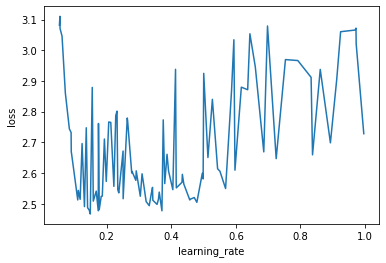

In [76]:
loss_plot('learning_rate', TRIALS)